# OCR and Document Analysis

This section of the nootbook demonstrates how to:
1. Extract text from PDFs and images using OCR or simple pdf extraction based on whats avalible 
2. Process and analyze the extracted text
3. Use LLMs to extract structured information from the text

In [ ]:
!pip3 install --upgrade --quiet langchain-community langchain-openai chromadb
!pip3 install --upgrade --quiet pypdf pandas streamlit python-dotenv
!pip3 install --upgrade --quiet pytesseract opencv-python pillow
!pip3 install --upgrade --quiet pdf2image PyPDF2

## Import Libraries

Import all necessary libraries for OCR, document processing, and analysis.

In [ ]:
# Import Langchain modules for a lot of things
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

import os
import tempfile
import streamlit as st  
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

# Import OCR libraries
import cv2
import pytesseract
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

OPENAPI_API_KEY = os.environ.get('OPENAI_API_KEY')  # Fetch the API key from .env file

# Defining LLM
llm = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAPI_API_KEY, temperature=0.2, max_tokens=2048)

## OCR Functions

Define functions for OCR processing and image preprocessing.

In [3]:
def preprocess_image(image_path):
    """
    Preprocess the image to improve OCR accuracy.
    """
    # Read the image
    img = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive threshold to handle different lighting conditions
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY, 11, 2)
    
    # Noise removal using median blur
    processed = cv2.medianBlur(thresh, 3)
    
    return processed

def perform_ocr(image, lang='eng', config='--psm 6'):
    """
    Perform OCR on the given image.
    """
    text = pytesseract.image_to_string(image, lang=lang, config=config)
    return text

def extract_text_from_image(image_path, preprocess=True):
    """
    Extract text from an image with optional preprocessing.
    """
    if preprocess:
        img = preprocess_image(image_path)
    else:
        img = cv2.imread(image_path)
    
    text = perform_ocr(img)
    return text

def extract_text_from_pdf(pdf_path):
    """
    Extract text from a PDF file using PyPDF and OCR.
    """
    from PyPDF2 import PdfReader
    from pdf2image import convert_from_path
    import tempfile
    
    text_results = []
    
    try:
        # First try direct text extraction with PyPDF
        pdf_reader = PdfReader(pdf_path)
        for page in pdf_reader.pages:
            text = page.extract_text()
            if text.strip():  # If we got meaningful text
                text_results.append(text)
            else:  # If no text was extracted, use OCR
                # Convert PDF page to image and run OCR
                images = convert_from_path(pdf_path)
                for i, image in enumerate(images):
                    # Save image to a temporary file
                    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp:
                        temp_filename = temp.name
                        image.save(temp_filename, 'PNG')
                    
                    # Run OCR on the image
                    img = cv2.imread(temp_filename)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    text = perform_ocr(gray)
                    text_results.append(text)
                    
                    # Clean up the temporary file
                    os.remove(temp_filename)
                    
        return "\n\n".join(text_results)
    
    except Exception as e:
        print(f"Error processing PDF: {e}")
        return ""

def visualize_ocr_results(image_path, text):
    """
    Display the original image and extracted text side by side.
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.5, text, fontsize=12, wrap=True)
    plt.axis('off')
    plt.title('Extracted Text')
    
    plt.tight_layout()
    plt.show()
    

## PDF Processing

Load and process PDF documents for analysis.

In [4]:
# Loading the PDF file
pdf_loader = PyPDFLoader('..//tests/Month-to-Month-Lease-Agreement-Sample.pdf')  # Load a legal document
pdf_pages = pdf_loader.load()  # Load all pages

# Split the PDF into relevant chunks (paragraphs/sentences)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200, length_function=len, separators=['\n\n', '\n', " "])
pdf_chunks = text_splitter.split_documents(pdf_pages)

# Display sample chunks to verify content
print(f"Total chunks: {len(pdf_chunks)}")
print("\nSample chunk content:")
if pdf_chunks:
    print(pdf_chunks[0].page_content[:200] + "...")

Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 36 0 (offset 0)
Ignoring wrong pointing object 38 0 (offset 0)
Ignoring wrong pointing object 40 0 (offset 0)


Total chunks: 24

Sample chunk content:
Page 1 of 7...


## Vector Embeddings and Storage

Create embeddings and store them in a vector database for retrieval.

In [5]:
# Embeddings model to represent the document chunks numerically
def get_embeddings():
    embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=OPENAPI_API_KEY)
    return embeddings_model

embedding_model = get_embeddings()

# Create a vector database
def create_vector_store(pdf_chunks, embedding_model, store_name):
    vectorstore = Chroma.from_documents(documents=pdf_chunks, embedding=embedding_model, persist_directory=store_name) 
    vectorstore.persist()  # Persist the vector store to make sure the folder is created
    return vectorstore

vectorstore = create_vector_store(pdf_chunks, embedding_model, "legal_vector_store")

# Query the database for relevant legal data
retriever = vectorstore.as_retriever(search_type="similarity")

/var/folders/23/rj3hwzds32x8m0hj4z25n9kh0000gn/T/ipykernel_59573/2147695287.py:11: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()  # Persist the vector store to make sure the folder is created


## RAG for Legal Document Analysis

Implement Retrieval Augmented Generation for legal document analysis.

In [6]:
# Legal-specific prompt template
prompt_template = """
You are a legal assistant specialized in extracting relevant legal information.
Use the following context to answer the question, if you don't know the answer, just say that you don't know, don't try to make up an answer.

{context}

---

Answer the question based on the context given above: {question}
"""

# Modify the format_docs function to return the context as a string
def format_docs(docs): 
    return "\n\n".join(doc.page_content for doc in docs)

# Create the prompt
prompt = ChatPromptTemplate.from_template(prompt_template)

# RAG chain construction to handle string input
def rag_chain(question):
    # 1. Retrieve relevant documents
    retrieved_docs = retriever.invoke(question)
    # 2. Format documents to get context
    context = format_docs(retrieved_docs)
    # 3. Create the input dictionary for the prompt
    input_data = {"context": context, "question": question}
    # 4. Format prompt with input data
    formatted_prompt = prompt.format(**input_data)
    # 5. Get response from LLM
    response = llm.invoke(formatted_prompt)
    return response

# Example query using the RAG chain
question = "What are the key legal points discussed in this rental agreement?"
response = rag_chain(question)
print(response.content)

The key legal points discussed in the rental agreement include:

1. **Display of Signs**: The landlord or their agent has the right to display "For Sale," "For Rent," "Vacancy," or similar signs on or around the premises and can enter to show the premises to prospective tenants during the last 60 days of the lease. The tenant is prohibited from placing any signs on the premises without the landlord's prior written consent.

2. **Noise Restrictions**: The tenant is not allowed to cause or permit any unreasonably loud noise or activities that may disturb the rights, comforts, and conveniences of other persons.

3. **Reasonable Attorney Fees and Costs**: The agreement mentions reasonable attorney fees and costs, although the specific context or application of this clause is not detailed in the provided text.


## Structured Information Extraction

Extract structured information from legal documents using Pydantic models.

In [7]:
# Structured Response using Pydantic to extract relevant legal data
class LegalAnswerWithSources(BaseModel):
    answer: str = Field(description="Answer to question")
    sources: str = Field(description="Full direct text chunk from the context used to answer the question")
    reasoning: str = Field(description="Explain the reasoning of the answer based on the sources")

class ExtractedLegalInfo(BaseModel):
    case_names_and_rulings: LegalAnswerWithSources  # Key legal cases and rulings discussed in the document
    statutory_references: LegalAnswerWithSources  # Relevant legal statutes or references
    court_decisions_and_outcomes: LegalAnswerWithSources  # Court decisions, opinions, and outcomes

In [ ]:
# Using structured output with the fixed chain approach
def structured_rag_chain(question):
    # Get relevant documents
    retrieved_docs = retriever.invoke(question)
    context = format_docs(retrieved_docs)
    
    # Create input for the prompt
    input_data = {"context": context, "question": question}
    
    # Format the prompt
    formatted_prompt = prompt.format(**input_data)
    
    # Get structured response
    structured_response = llm.with_structured_output(ExtractedLegalInfo).invoke(formatted_prompt)
    return structured_response

# Get structured response
structured_result = structured_rag_chain("What are the key legal points discussed in this rental agreement?")
print(structured_result)

## Format and Display Results

Process structured results into a formatted dataframe for better readability.

In [11]:
# Convert the structured result to a more readable format
def format_structured_result(result):
    # Create dictionary representation of the result
    result_dict = {
        "case_names_and_rulings": {
            "answer": result.case_names_and_rulings.answer,
            "sources": result.case_names_and_rulings.sources,
            "reasoning": result.case_names_and_rulings.reasoning
        },
        "statutory_references": {
            "answer": result.statutory_references.answer,
            "sources": result.statutory_references.sources,
            "reasoning": result.statutory_references.reasoning
        },
        "court_decisions_and_outcomes": {
            "answer": result.court_decisions_and_outcomes.answer,
            "sources": result.court_decisions_and_outcomes.sources,
            "reasoning": result.court_decisions_and_outcomes.reasoning
        }
    }
    
    # Set pandas display options to show full content
    pd.set_option('display.max_colwidth', None)  # Don't truncate column content
    pd.set_option('display.width', 1000)         # Wider display area
    pd.set_option('display.max_rows', None)      # Show all rows
    
    # Create a nicely formatted dataframe
    df = pd.DataFrame.from_dict({
        (category, field): value
        for category, fields in result_dict.items()
        for field, value in fields.items()
    }, orient='index')
    
    # Rename the columns for clarity
    df.columns = ['Content']
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Category', 'Field'])
    
    return df

# Format and display the structured result
formatted_df = format_structured_result(structured_result)
print("Structured Legal Information Extracted from Document:")
display(formatted_df)

Structured Legal Information Extracted from Document:


Content
Category                     Field                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
case_names_and_rulings       answer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          The rental agreement discusses the display of signs and noise restrictions.
                             sources    reasonable attorney fees and costs.   35. Display of Signs: Landlord or Landlord’s agent may display “For Sale” or “For Rent” or “Vacancy” or similar signs on or about the Premises and enter to show the Premises to prospective tenants during the last 60 days of this Lease.  Tenant agrees that no signs shall be placed on the Premises without the prior written consent of the Landlord.  36. Noise: Tenant shall not cause or allow any unreasonably loud noise or activity in the Premises that might disturb the rights, comforts and conveniences of other persons.
                             reasoning                                                                                                                                                                                                                                                                                                                                                                             The key legal points include the landlord's right to display signs related to the rental of the property and the tenant's obligation to maintain a reasonable noise level to avoid disturbing others.
statutory_references         answer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             The agreement includes provisions regarding the display of signs and noise restrictions.
                             sources    reasonable attorney fees and costs.   35. Display of Signs: Landlord or Landlord’s agent may display “For Sale” or “For Rent” or “Vacancy” or similar signs on or about the Premises and enter to show the Premises to prospective tenants during the last 60 days of this Lease.  Tenant agrees that no signs shall be placed on the Premises without the prior written consent of the Landlord.  36. Noise: Tenant shall not cause or allow any unreasonably loud noise or activity in the Premises that might disturb the rights, comforts and conveniences of other persons.
                             reasoning                                                                                                                                                                                                                                                                                                                                                            

## OCR Example

Example of using OCR to extract text from an image. To use this, you'll need to provide a path to an image file.

In [12]:
# Make sure you have the required libraries
# Example OCR usage - handling both PDFs and images
image_path = "..//tests/Month-to-Month-Lease-Agreement-Sample.pdf"

if image_path.lower().endswith('.pdf'):
    extracted_text = extract_text_from_pdf(image_path)
    # We can't use visualize_ocr_results directly with a PDF
    print(f"Extracted text from PDF (first 500 chars):\n{extracted_text[:500]}...")
else:
    # For regular image files
    extracted_text = extract_text_from_image(image_path)
    visualize_ocr_results(image_path, extracted_text)

Extracted text from PDF (first 500 chars):
    
Page 1 of 7  MONTH-TO-MONTH LEASE AGREEMENT  This Lease Agreement (“Lease”) is entered by and between David Jones (“Landlord”) and Rachel Johnson (“Tenant”) on August 22nd, 2020. Landlord and Tenant may collectively be referred to as the “Parties.” This Lease creates joint and several liabilities in the case of multiple Tenants. The Parties agree as follows:  1. Premises: Landlord hereby leases the premises located at 1555 Main Street Unit 3 in the City of Atlanta, State of Georgia, (the “P...


## Conclusion

This notebook demonstrates how to:
1. Extract text from documents using OCR or PDF parsing based on avalibility
2. Process the text using NLP techniques
3. Use LLMs to extract structured information from legal documents
4. Present the information in a well-organized format

The techniques shown here can be applied to various document analysis tasks beyond legal documents.

# Initial Experiments
The code loads pre-trained summarization models (like BART, T5, and DistilBART) and uses them to generate summaries from input text. It includes functions to load models and tokenizers, summarize text, and evaluate the summarization quality using the ROUGE metric. This setup allows you to automatically summarize large texts and assess the quality of the summaries.

In [ ]:
!pip3 install transformers
!pip3 install torch
!pip3 install evaluate
!pip3 install tf-keras
!pip3 install rouge_score nltk

Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


BART: 4.2718 seconds
T5: 0.6544 seconds
DistilBART: 2.0311 seconds


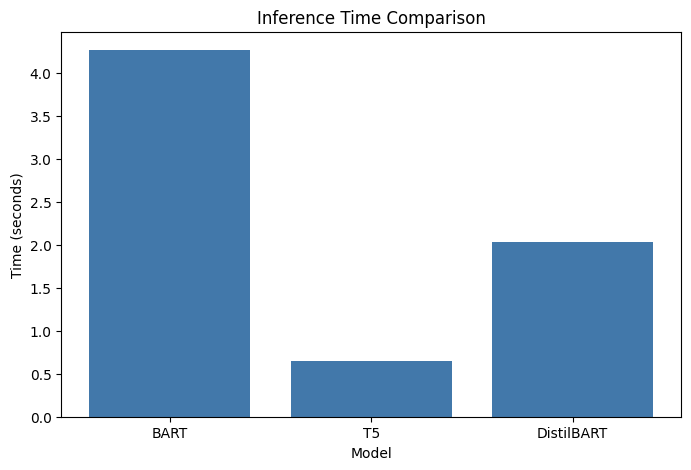

In [5]:
# Import necessary libraries
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import time
import torch
import evaluate  
import matplotlib.pyplot as plt

# Load summarization pipeline (early prototypes)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Example: Summarize a long article
def summarize(text):
    return summarizer(text, max_length=150, min_length=40, do_sample=False)[0]['summary_text']

# Models evaluated
models = {
    "BART": "facebook/bart-large-cnn",
    "T5": "t5-small",
    "DistilBART": "sshleifer/distilbart-cnn-12-6"
}

# Load ROUGE metric
rouge = evaluate.load("rouge")  

# Function to load a model and tokenizer
def load_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    return tokenizer, model

# Function to evaluate summary quality
def evaluate_summary(reference, generated):
    results = rouge.compute(predictions=[generated], references=[reference])
    return {
        "ROUGE-1": results["rouge1"],
        "ROUGE-2": results["rouge2"],
        "ROUGE-L": results["rougeL"]
    }

# Function to measure compute cost
def measure_inference_time(model_name, text):
    tokenizer, model = load_model(model_name)
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    
    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=40)
    end_time = time.time()

    inference_time = end_time - start_time
    return inference_time

# Example text
text = """
This is a sample text that we will use to evaluate the summarization models. It contains a lot of information that we want to summarize. 
The goal is to see how well each model performs in terms of generating a concise summary while retaining the key points from the original text.
We will compare the models based on their ROUGE scores and inference time. 
"""

# Measure inference time for each model
times = []
for model_name, model_path in models.items():
    t = measure_inference_time(model_path, text)
    print(f"{model_name}: {t:.4f} seconds")
    times.append(t)

# Plot
plt.figure(figsize=(8,5))
plt.bar(models.keys(), times, color='#4278aa')
plt.title("Inference Time Comparison")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.show()
